# Data-driven Modeling
From wikipedia: "Data-driven models are a class of computational models that primarily rely on historical data collected throughout a system's or process' lifetime to establish relationships between input, internal, and output variables."

Data-driven models are - at their highest level - <i>any</i> model that uses data to inform predictions. I.e., I take offense with "primarily" in the above definition.

Contrast this with purely physics-based models that use hypotheses, (or maybe even just guesses) to relate inputs to outputs.

## Motivation
As an example of these two regimes, suppose we want to make predictions about a simple variable $y(x)$

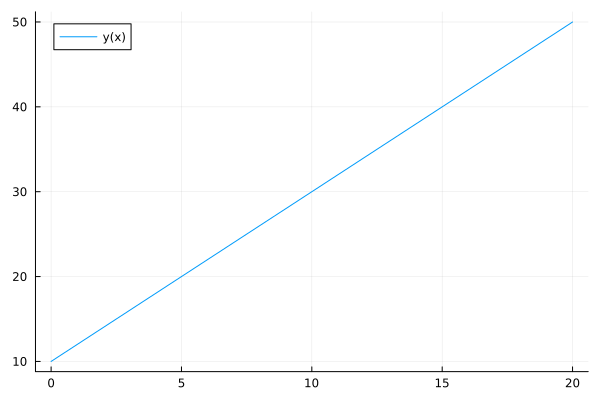

In [7]:
x = 0:0.25:20;
y(x) = 2x + 10;
using Plots, StatsBase
plot(x, y.(x), label="y(x)")

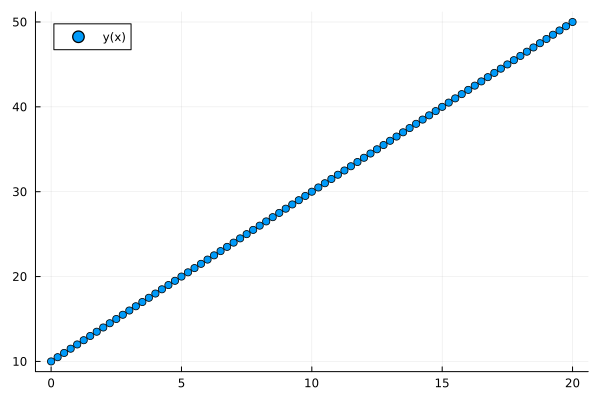

In [8]:
scatter(x, y.(x), label="y(x)")

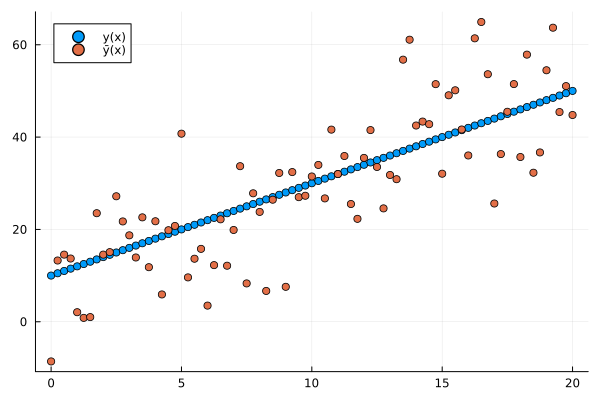

In [9]:
ȳ(x) = 2x + 10 + 10*randn()
scatter!(x, ȳ.(x), label="ȳ(x)")

In [10]:
mse(x,y) = mean((x.-y).^2)

mse (generic function with 1 method)

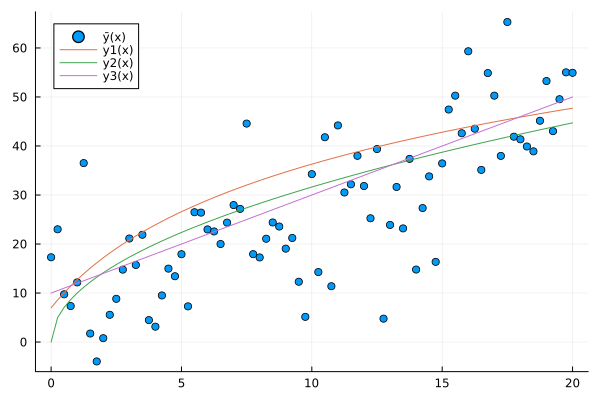

In [11]:
y1(x) = 20*log(x+3)-15;
y2(x) = 10*sqrt(x);
y3(x) = y(x)
scatter(x, ȳ.(x), label="ȳ(x)")
plot!(x, y1.(x), label="y1(x)")
plot!(x, y2.(x), label="y2(x)")
plot!(x, y3.(x), label="y3(x)")

In [12]:
println(mse(ȳ.(x),y1.(x)))
println(mse(ȳ.(x),y2.(x)))
println(mse(ȳ.(x),y.(x)))

133.21501737755375
127.9673001026411
97.52098215601454


Without any knowledge of physics, choosing between functional forms is usually an underdetermined problem, but without information of data, we are left to guess at the parameters of these functional forms.

## Linear Regression & Least Squares

$y = mx + b$ is equivalent to $y = Ax$ for an augmented $A = [m, b]$ and $x = [x, 1]$. To find $A$...TODO fill in

In [13]:
X = vcat([[1 x[i]] for i in 1:length(x)]...);
Y = ȳ.(x);
A = ((transpose(X)*X)^(-1))*transpose(X)*Y

2-element Vector{Float64}:
 11.089256748770111
  1.8079317057936617

## Least Squares & Polynomial fit
We can generalize this process to fitting $n$th order polynomials by letting $X=[1, x_i, x_i^2, ..., x_i^N]$

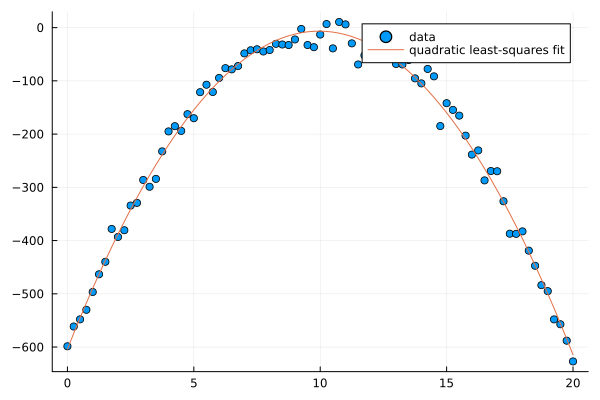

In [14]:
w(x) = -6*(x-10)^2+20*randn(); #-6x^2+120x-600
W = w.(x);
scatter(x,W, label="data")

X = vcat([[1 x[i] x[i]^2] for i in 1:length(x)]...);
B = ((transpose(X)*X)^(-1))*transpose(X)*W
plot!(x,X*B, label="quadratic least-squares fit")

## Timeseries Learning
Suppose instead of $y(x)$, we were trying to predict $y(t)$ or $y(x(t))$. We could still perform a linear regression, or apply a neural network, but we'd be neglecting one of the most developed areas of mathematics: differential equations!

Differential equations allow us to hypothesize additional structure to our data. Instead of viewing $y(t)$ as a simple collection of data, we can hypothesize that $$\frac{dy}{dt} = f(y,t)$$.

For example, suppose we're given the data in https://www.math.arizona.edu/~klin/reu/2021/week4/data-long.csv, and asked to find a model that fits it.

In [15]:
using CSV;
file = CSV.File(download("https://www.math.arizona.edu/~klin/reu/2021/week4/data-long.csv"))

10000-element CSV.File:
 CSV.Row: (t = 0.0, x = 0.000387949811920821)
 CSV.Row: (t = 0.1, x = 0.0001559804897398102)
 CSV.Row: (t = 0.2, x = 0.00039473774132526976)
 CSV.Row: (t = 0.3, x = 0.00022876365967345306)
 CSV.Row: (t = 0.4, x = 0.00017107632826886265)
 CSV.Row: (t = 0.5, x = 0.00023050800324315738)
 CSV.Row: (t = 0.6, x = 0.0004890332128112515)
 CSV.Row: (t = 0.7, x = 0.00038042375074604596)
 CSV.Row: (t = 0.8, x = 0.00036708806620455633)
 CSV.Row: (t = 0.9, x = 0.000424687545823066)
 CSV.Row: (t = 1.0, x = 0.0002760375194461288)
 CSV.Row: (t = 1.1, x = 0.0005838595869234488)
 CSV.Row: (t = 1.2, x = 0.0004338770374448688)
 ⋮
 CSV.Row: (t = 998.8, x = 0.3000460049745396)
 CSV.Row: (t = 998.9, x = 0.3000713281499093)
 CSV.Row: (t = 999.0, x = 0.3001716250092923)
 CSV.Row: (t = 999.1, x = 0.3000565389191074)
 CSV.Row: (t = 999.2, x = 0.30014854413238395)
 CSV.Row: (t = 999.3, x = 0.3000118270411409)
 CSV.Row: (t = 999.4, x = 0.2999890966277178)
 CSV.Row: (t = 999.5, x = 0.3000500

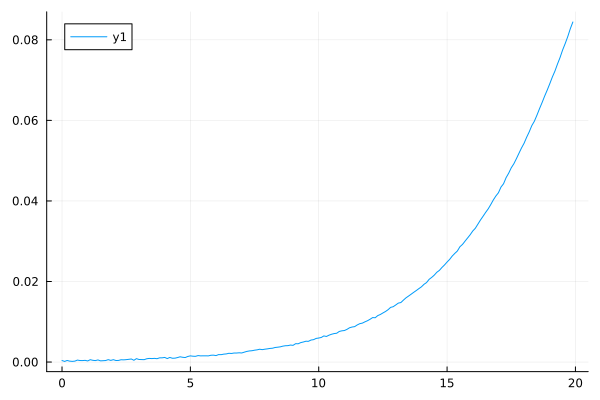

In [39]:
plot(file.t[1:200], file.x[1:200])

We might hypothesize that $$\frac{dx}{dt} = f(x,t) = c_0 + c_1*x + c_2*x^2 + \dots $$
For simplicity, let's use a low order approximation $f(x,t) \approx c_0 + c_1*x$.

The simplest update rule for a differential equation is given by forward Euler:
$$ x_{n+1} = x_n + \Delta t \cdot f(x_n, t_n) $$
and substituting our low-order guess of $f(x,t)$,
$$ x_{n+1} = x_n + \Delta t \cdot \left(c_0 + c_1*x_n\right) = \Delta t \cdot c_0 + (1+\Delta t \cdot c_1)x_n$$

Since $c_0, c_1$ are yet to be determined constants, I'll simply state: $x_{n+1} = c_0 + c_1\cdot x_n$.

We want to find the values of $c_0, c_1$ to minimize the difference between predicted and actual data. If we use the $\ell_2$ norm, this takes the form:
$$ \min_{c_0, c_1} \sum_{i = 1}^{N-1} \lVert x_{n+1} - \left( c_0 + c_1 \cdot x_n \right) \rVert_2^2 $$

Looking at this, this is just a linear regression! Let $W = \{x_{i}\}_{i \in [2,N]}$ and $Y = \{ x_i \}_{i \in [1,N-1]}$, and $\beta = [c_0, c_1]$.

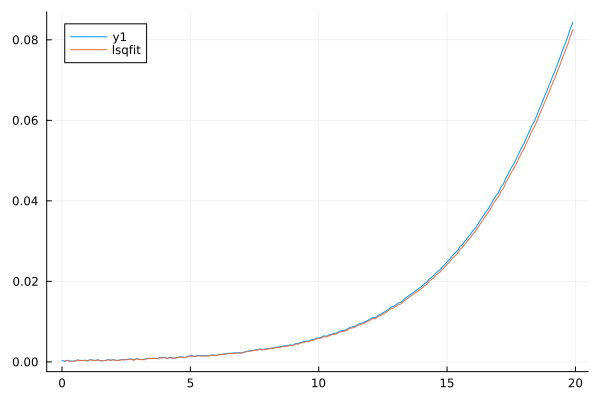

In [40]:
W = vcat([[1 file.x[i]] for i in 2:200]...);
Y = file.x[1:200-1];
B = W\Y
plot!(file.t[2:200], W*B, label="lsqfit")